# Fruit Image Classification: An Exploration of Deep Learning Models

**Project Notebook**

Jack Haas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import PIL
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model, load_model

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Data Prep and Exploratory Data Analysis

### Creating Homemade Dataset

Converting HEIC images to JPG:

```bash
for img in *.heic; do
    filename=${img%.*}
    magick convert "$filename.heic" "$filename.jpg"
done
```

Resizing images to be consistent with dataset:

```bash
for img in *.heic; do
    filename=${img%.*}
    convert "$filename.jpg" -resize 100x100 "${filename}_100.jpg"
done
```

Performing image segmentation with the [remove.bg API](https://www.remove.bg/tools-api):

```python
import glob
import os
import requests
from PIL import Image
import numpy as np

paths = glob.glob('./making_homemade/*_100.jpg')

for img in paths:
    dirname = os.path.dirname(img)
    filename = os.path.basename(img).replace('.jpg', '')
    dest = dirname + '/' + filename + '_seg.png'
    
    # remove.bg
    response = requests.post(
        'https://api.remove.bg/v1.0/removebg',
        files={'image_file': open(img, 'rb')},
        data={'size': 'auto'},
        headers={'X-Api-Key': api_key},
    )
    if response.status_code == requests.codes.ok:
        with open(dest, 'wb') as out:
            out.write(response.content)
    else:
        print("Error:", response.status_code, response.text)
```

Converting segmented images back to JPG with white backgrounds:

```bash
for img in *_seg.png; do
    filename=${img%.*}
    convert "$filename.png" -background white -alpha remove -alpha off "${filename}_white.jpg"
done
```

### Exploring Datasets

In [4]:
train_path = './fruits-360_dataset/fruits-360/Training'
test_path = './fruits-360_dataset/fruits-360/Test/'
home_path = './Homemade/'

/tmp/local/51409462/ipykernel_185100/2149142265.py:15: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.gca().set_xticks([])
/tmp/local/51409462/ipykernel_185100/2149142265.py:27: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.gca().set_xticks([])


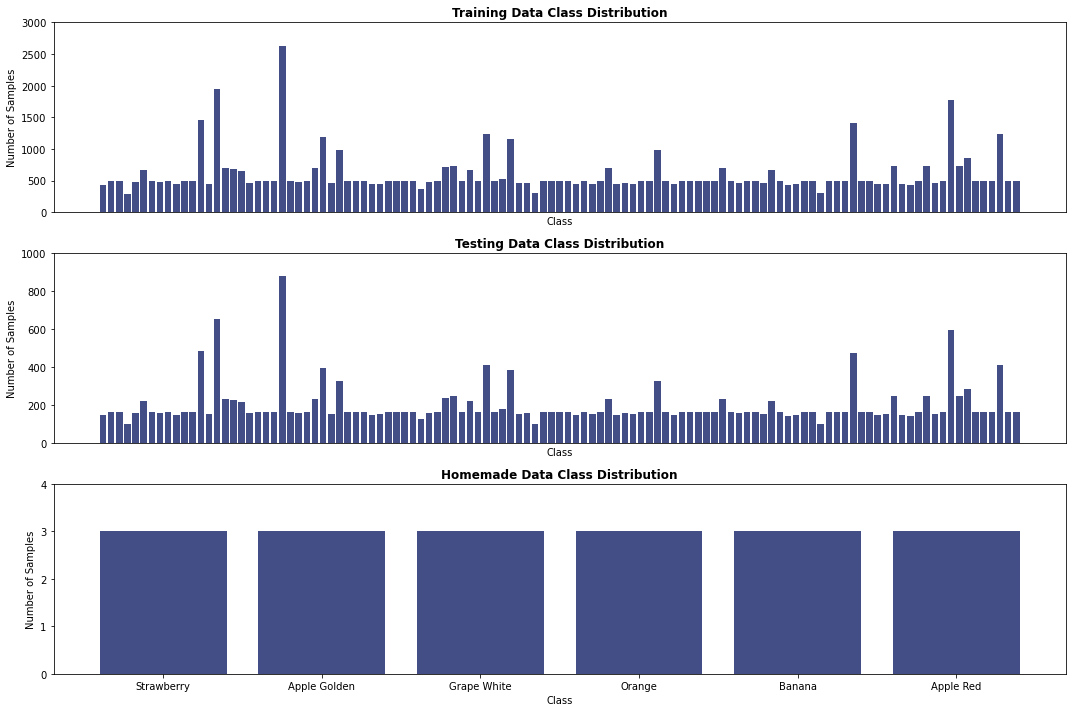

In [117]:
# creating class distribution visualization
x = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
 
y_1 = 2*x
 
y_2 = 3*x

plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
len_dic = {}
for fruit in os.listdir(train_path):
    len_dic[fruit] = len(os.listdir(train_path+'/'+fruit))
plt.bar(list(len_dic.keys()), list(len_dic.values()), color='#444e86') 
plt.gca().set_xticks([])
plt.gca().set_xticklabels([])
plt.title('Training Data Class Distribution', weight='semibold')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.ylim(0,3000)

plt.subplot(3, 1, 2)
len_dic = {}
for fruit in os.listdir(test_path):
    len_dic[fruit] = len(os.listdir(test_path+'/'+fruit))
plt.bar(list(len_dic.keys()), list(len_dic.values()), color='#444e86') 
plt.gca().set_xticks([])
plt.gca().set_xticklabels([])
plt.title('Testing Data Class Distribution', weight='semibold')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.ylim(0,1000)

plt.subplot(3, 1, 3)
len_dic = {}
for fruit in os.listdir(home_path):
    len_dic[fruit] = len(os.listdir(home_path+'/'+fruit))
plt.bar(list(len_dic.keys()), list(len_dic.values()), color='#444e86') 
plt.title('Homemade Data Class Distribution', weight='semibold')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.ylim(0,4)
plt.gca().set_yticks([0,1,2,3,4])
plt.gca().set_yticklabels([0,1,2,3,4])
 
plt.tight_layout()

# plt.savefig('class_dist.png', dpi=400)

plt.show()

In [44]:
# creating parallel coordinates PCA visualization
train_img_paths = [] 
for root, dirs, files in os.walk(train_path):
    for file in files:
        train_img_paths.append(os.path.join(root,file))

flat_imgs = []
for img_path in train_img_paths:
    img = PIL.Image.open(img_path)
    flat_imgs.append(np.asarray(img).flatten())
flat_imgs = np.array(flat_imgs)

In [48]:
pca = PCA(n_components=1000)
pca.fit(flat_imgs)

PCA(n_components=1000)

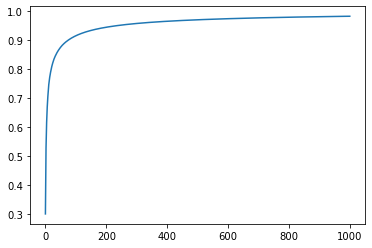

In [51]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [62]:
np.cumsum(pca.explained_variance_ratio_)[76]

0.900542854888658

In [63]:
flat_imgs_pca = pca.transform(flat_imgs)

In [70]:
print(flat_imgs_pca.shape)
flat_imgs_reduced = flat_imgs_pca[:,:77]
print(flat_imgs_reduced.shape)

(67692, 1000)
(67692, 77)


In [80]:
# scale pcas 
scaler = MinMaxScaler()
scaler.fit(flat_imgs_reduced)
scaled_red_imgs = scaler.transform(flat_imgs_reduced)

In [94]:
# getting pca values for homemade images
home_img_paths = [] 
for root, dirs, files in os.walk(home_path):
    for file in files:
        home_img_paths.append(os.path.join(root,file))

flat_imgs_home = []
for img_path in home_img_paths:
    img = PIL.Image.open(img_path)
    flat_imgs_home.append(np.asarray(img).flatten())
flat_imgs_home = np.array(flat_imgs_home)

flat_imgs_home_red = pca.transform(flat_imgs_home)[:,:77]
flat_imgs_home_scaled = scaler.transform(flat_imgs_home_red)

In [112]:
from matplotlib.lines import Line2D

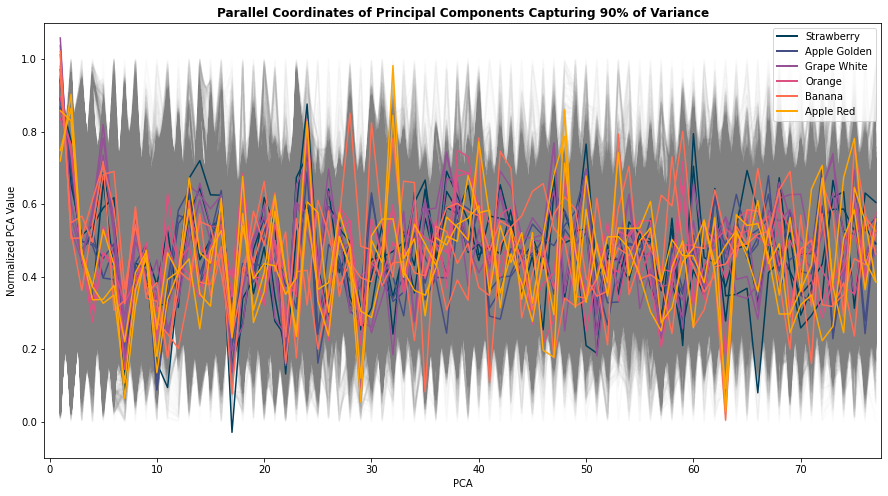

In [120]:
inds = np.arange(1,78)

plt.figure(figsize=(15,8))

plt.title('Parallel Coordinates of Principal Components Capturing 90% of Variance', weight='semibold')
plt.xlabel('PCA')
plt.xlim(-0.5, 77.5)
plt.ylabel('Normalized PCA Value')
plt.ylim(-0.1, 1.1)

for red_img in scaled_red_imgs:
    plt.plot(inds, red_img, c='grey', alpha=0.02)

c1 = '#003f5c'
c2 = '#444e86'
c3 = '#955196'
c4 = '#dd5182'
c5 = '#ff6e54'
c6 = '#ffa600'

cols = [c1]*3 + [c2]*3 + [c3]*3 + [c4]*3 + [c5]*3 + [c6]*3
    
for i in range(len(cols)):
    plt.plot(inds, flat_imgs_home_scaled[i], c=cols[i])
    
custom_lines = [Line2D([0], [0], color=c1, lw=2),
                Line2D([0], [0], color=c2, lw=2),
                Line2D([0], [0], color=c3, lw=2),
                Line2D([0], [0], color=c4, lw=2),
                Line2D([0], [0], color=c5, lw=2),
                Line2D([0], [0], color=c6, lw=2)]

plt.gca().legend(custom_lines, ['Strawberry', 'Apple Golden', 'Grape White', 'Orange', 'Banana', 'Apple Red'], 
                loc='upper right')

plt.savefig('pca_parallel_coords.png', dpi=400)

plt.show()

### Loading Images

In [9]:
batch_size = 32
img_height = 100
img_width = 100

print('Training:')
train_ds = tf.keras.utils.image_dataset_from_directory(
              train_path,
              validation_split=0.2,
              subset="training",
              seed=0,
              image_size=(img_height, img_width),
              batch_size=batch_size)

print('\nValidation:')
val_ds = tf.keras.utils.image_dataset_from_directory(
              train_path,
              validation_split=0.2,
              subset="validation",
              seed=0,
              image_size=(img_height, img_width),
              batch_size=batch_size)

print('\nTesting:')
test_ds = tf.keras.utils.image_dataset_from_directory(
              test_path,
              seed=0,
              image_size=(img_height, img_width),
              batch_size=batch_size)

print('\nHomemade:')
home_ds = tf.keras.utils.image_dataset_from_directory(
              home_path,
              seed=0,
              image_size=(img_height, img_width),
              batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

Training:
Found 67692 files belonging to 113 classes.
Using 54154 files for training.


2022-04-13 19:59:38.518460: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Validation:
Found 67692 files belonging to 113 classes.
Using 13538 files for validation.

Testing:
Found 22688 files belonging to 113 classes.

Homemade:
Found 18 files belonging to 6 classes.


### Visualizing Raw Images

Training:


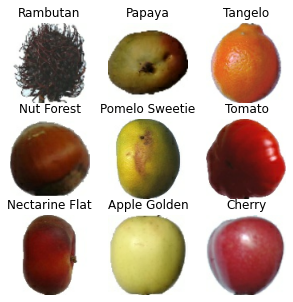


Validation:


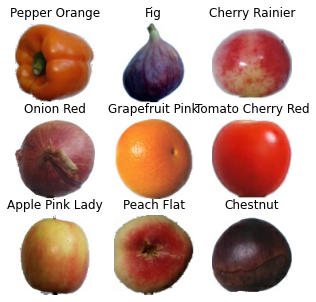


Testing:


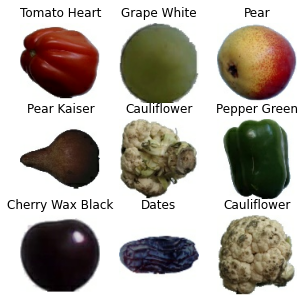


Homemade:


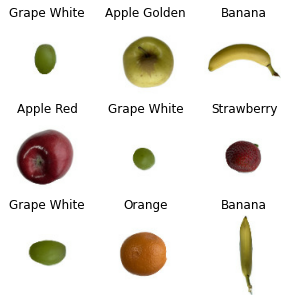

In [10]:
print('Training:')
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()
    
print('\nValidation:')
plt.figure(figsize=(5, 5))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

print('\nTesting:')
plt.figure(figsize=(5, 5))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

print('\nHomemade:')
plt.figure(figsize=(5, 5))
for images, labels in home_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(home_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

### Saving Visuals of Raw and Homemade Images

In [127]:
def show_3_images(ims, titles=None, save=False):
    plt.figure(figsize=(15,15))
    for i in range(len(ims)):
        ax = plt.subplot(3, 3, i + 1)
        im = PIL.Image.open(ims[i])
        plt.imshow(im, interpolation='nearest')
        if titles:
            plt.title(titles[i])
    if save:
        plt.savefig(save, dpi=400)

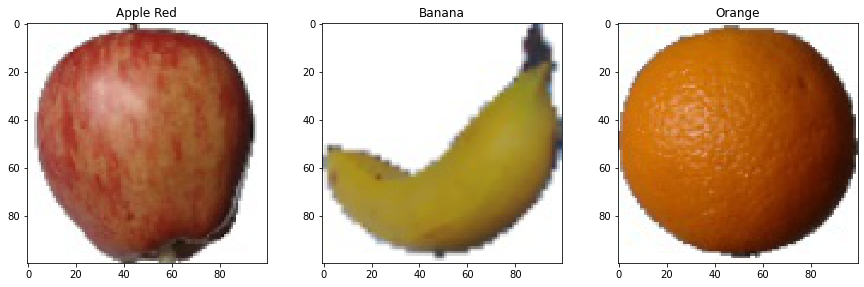

In [136]:
train_ims = ['./fruits-360_dataset/fruits-360/Training/Apple Red/1_0_100.jpg', 
            './fruits-360_dataset/fruits-360/Training/Banana/0_100.jpg',
            './fruits-360_dataset/fruits-360/Training/Orange/0_100.jpg']
titles = ['Apple Red', 'Banana', 'Orange']

show_3_images(train_ims, titles=titles, save='train_images.png')

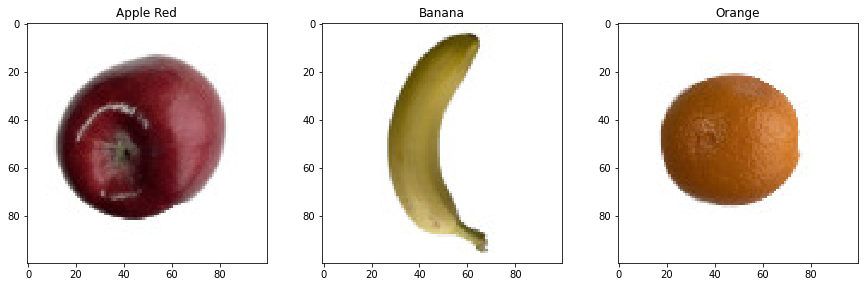

In [132]:
home_ims = ['./Homemade/Apple Red/apple_red_02_100_seg_white.jpg', 
            './Homemade/Banana/banana_01_100_seg_white.jpg',
            './Homemade/Orange/orange_01_100_seg_white.jpg']
titles = ['Apple Red', 'Banana', 'Orange']

show_3_images(home_ims, titles=titles, save='home_images.png')

### Augmenting Images

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(1, fill_mode="constant", seed=42, fill_value=255),
    layers.RandomZoom(0.2, fill_mode="constant", seed=42, fill_value=255),
  ]
)

aug_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
aug_val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))
aug_test_ds = test_ds.map(lambda x, y: (data_augmentation(x), y))
aug_home_ds = home_ds.map(lambda x, y: (data_augmentation(x), y))

### Visualizing Augmented Images

Training:


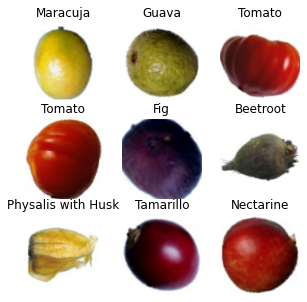


Validation:


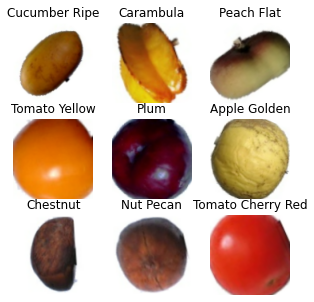


Testing:


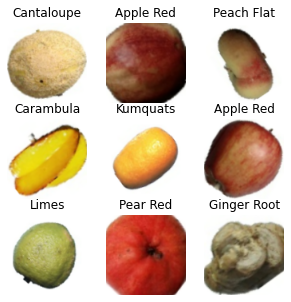


Homemade:


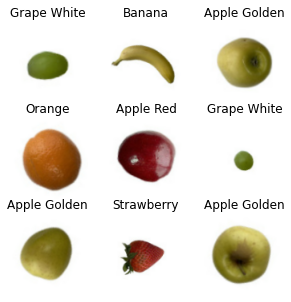

In [12]:
print('Training:')
plt.figure(figsize=(5, 5))
for images, labels in aug_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()
    
print('\nValidation:')
plt.figure(figsize=(5, 5))
for images, labels in aug_val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

print('\nTesting:')
plt.figure(figsize=(5, 5))
for images, labels in aug_test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

print('\nHomemade:')
plt.figure(figsize=(5, 5))
for images, labels in aug_home_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(home_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

## Model Training

### No Convolutional Layers

#### Trained on Raw Images

In [39]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Flatten(),
    layers.Dense(100*3, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 13s 8ms/step - loss: 1.5522 - accuracy: 0.6246 - val_loss: 0.3793 - val_accuracy: 0.8745
Epoch 2/10
1693/1693 [==============================] - 12s 7ms/step - loss: 0.2867 - accuracy: 0.9079 - val_loss: 0.1653 - val_accuracy: 0.9506
Epoch 3/10
1693/1693 [==============================] - 13s 7ms/step - loss: 0.2287 - accuracy: 0.9282 - val_loss: 0.2319 - val_accuracy: 0.9207
Epoch 4/10
1693/1693 [==============================] - 13s 7ms/step - loss: 0.2024 - accuracy: 0.9415 - val_loss: 0.3247 - val_accuracy: 0.9153
Epoch 5/10
1693/1693 [==============================] - 13s 8ms/step - loss: 0.1782 - accuracy: 0.9488 - val_loss: 0.1548 - val_accuracy: 0.9504
Epoch 6/10
1693/1693 [==============================] - 13s 8ms/step - loss: 0.1610 - accuracy: 0.9555 - val_loss: 0.2135 - val_accuracy: 0.9408
Epoch 7/10
1693/1693 [==============================] - 13s 7ms/step - loss: 0.1496 - accuracy: 0.9594 - val_loss: 0.1687 - val_ac

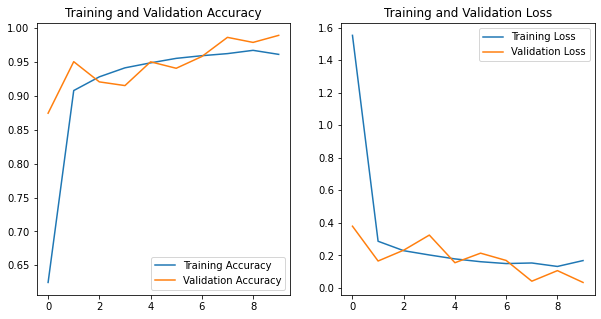

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/seq_raw_training.png', dpi=400)

plt.show()

In [41]:
# filepath = './models/seq_raw'
# save_model(model, filepath)

INFO:tensorflow:Assets written to: ./models/seq_raw/assets


#### Trained on Augmented Images

In [42]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Flatten(),
    layers.Dense(100*3, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history = model.fit(
  aug_train_ds,
  validation_data=aug_val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 275s 162ms/step - loss: 2.5112 - accuracy: 0.3631 - val_loss: 1.0584 - val_accuracy: 0.6540
Epoch 2/10
1693/1693 [==============================] - 278s 164ms/step - loss: 1.0098 - accuracy: 0.6688 - val_loss: 1.1548 - val_accuracy: 0.6144
Epoch 3/10
1693/1693 [==============================] - 280s 165ms/step - loss: 0.8383 - accuracy: 0.7214 - val_loss: 0.6839 - val_accuracy: 0.7691
Epoch 4/10
1693/1693 [==============================] - 275s 162ms/step - loss: 0.7600 - accuracy: 0.7457 - val_loss: 0.8298 - val_accuracy: 0.7226
Epoch 5/10
1693/1693 [==============================] - 276s 163ms/step - loss: 0.7103 - accuracy: 0.7642 - val_loss: 0.6427 - val_accuracy: 0.7833
Epoch 6/10
1693/1693 [==============================] - 274s 162ms/step - loss: 0.6714 - accuracy: 0.7747 - val_loss: 0.5818 - val_accuracy: 0.8082
Epoch 7/10
1693/1693 [==============================] - 276s 163ms/step - loss: 0.6244 - accuracy: 0.7906 - val_

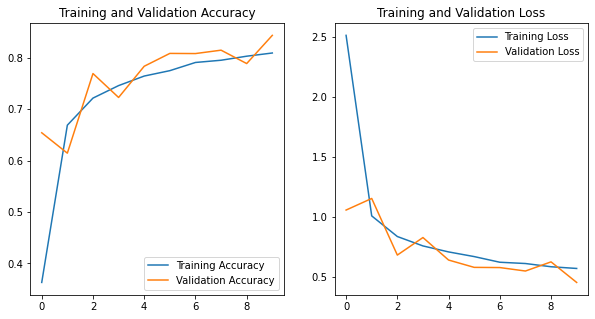

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/seq_aug_training.png', dpi=400)

plt.show()

In [44]:
# filepath = './models/seq_aug'
# save_model(model, filepath)

INFO:tensorflow:Assets written to: ./models/seq_aug/assets


### 1 Convolutional Layer

#### Trained on Raw Images

In [24]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 58s 31ms/step - loss: 1.3605 - accuracy: 0.6745 - val_loss: 0.2563 - val_accuracy: 0.9281
Epoch 2/10
1693/1693 [==============================] - 33s 20ms/step - loss: 0.1358 - accuracy: 0.9632 - val_loss: 0.0655 - val_accuracy: 0.9826
Epoch 3/10
1693/1693 [==============================] - 33s 19ms/step - loss: 0.0582 - accuracy: 0.9839 - val_loss: 0.0387 - val_accuracy: 0.9879
Epoch 4/10
1693/1693 [==============================] - 33s 19ms/step - loss: 0.0438 - accuracy: 0.9873 - val_loss: 0.0147 - val_accuracy: 0.9972
Epoch 5/10
1693/1693 [==============================] - 33s 20ms/step - loss: 0.0325 - accuracy: 0.9906 - val_loss: 0.0400 - val_accuracy: 0.9891
Epoch 6/10
1693/1693 [==============================] - 33s 19ms/step - loss: 0.0206 - accuracy: 0.9943 - val_loss: 0.0120 - val_accuracy: 0.9968
Epoch 7/10
1693/1693 [==============================] - 33s 19ms/step - loss: 0.0265 - accuracy: 0.9926 - val_loss: 0.0044 -

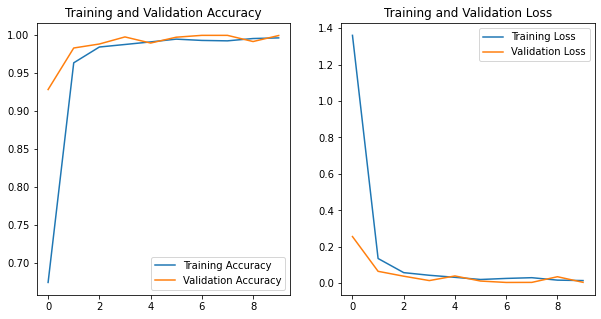

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/cnn_raw_1_training.png', dpi=400)

plt.show()

In [26]:
# filepath = './models/cnn_1_raw'
# save_model(model, filepath)

2022-04-09 12:30:58.575413: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/cnn_1_raw/assets


#### Trained on Augmented Images

In [27]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history = model.fit(
  aug_train_ds,
  validation_data=aug_val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 303s 179ms/step - loss: 2.7054 - accuracy: 0.2692 - val_loss: 1.7420 - val_accuracy: 0.4521
Epoch 2/10
1693/1693 [==============================] - 303s 179ms/step - loss: 1.5925 - accuracy: 0.4895 - val_loss: 1.4717 - val_accuracy: 0.5266
Epoch 3/10
1693/1693 [==============================] - 301s 178ms/step - loss: 1.4066 - accuracy: 0.5521 - val_loss: 1.3177 - val_accuracy: 0.5767
Epoch 4/10
1693/1693 [==============================] - 303s 179ms/step - loss: 1.2910 - accuracy: 0.5946 - val_loss: 1.2069 - val_accuracy: 0.6135
Epoch 5/10
1693/1693 [==============================] - 301s 178ms/step - loss: 1.1828 - accuracy: 0.6355 - val_loss: 1.1513 - val_accuracy: 0.6299
Epoch 6/10
1693/1693 [==============================] - 300s 177ms/step - loss: 1.0916 - accuracy: 0.6641 - val_loss: 1.0913 - val_accuracy: 0.6573
Epoch 7/10
1693/1693 [==============================] - 301s 178ms/step - loss: 1.0356 - accuracy: 0.6827 - val_

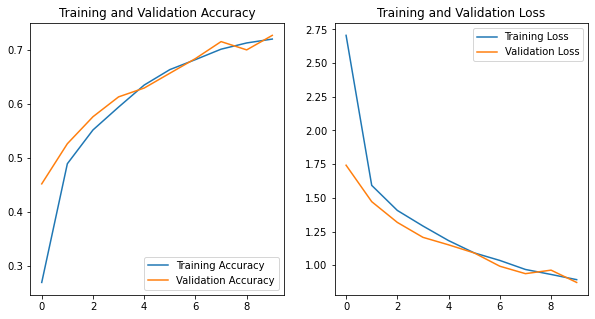

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/cnn_aug_1_training.png', dpi=400)

plt.show()

In [29]:
# filepath = './models/cnn_1_aug'
# save_model(model, filepath)

INFO:tensorflow:Assets written to: ./models/cnn_1_aug/assets


### 2 Convolutional Layers

#### Trained on Raw Images

In [30]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 38s 22ms/step - loss: 0.5346 - accuracy: 0.8721 - val_loss: 0.0364 - val_accuracy: 0.9917
Epoch 2/10
1693/1693 [==============================] - 36s 21ms/step - loss: 0.0313 - accuracy: 0.9914 - val_loss: 0.0476 - val_accuracy: 0.9827
Epoch 3/10
1693/1693 [==============================] - 36s 21ms/step - loss: 0.0202 - accuracy: 0.9943 - val_loss: 7.5144e-04 - val_accuracy: 0.9998
Epoch 4/10
1693/1693 [==============================] - 35s 21ms/step - loss: 0.0258 - accuracy: 0.9932 - val_loss: 0.0381 - val_accuracy: 0.9909
Epoch 5/10
1693/1693 [==============================] - 35s 21ms/step - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.0032 - val_accuracy: 0.9991
Epoch 6/10
1693/1693 [==============================] - 35s 21ms/step - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0.0013 - val_accuracy: 0.9998
Epoch 7/10
1693/1693 [==============================] - 35s 21ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.00

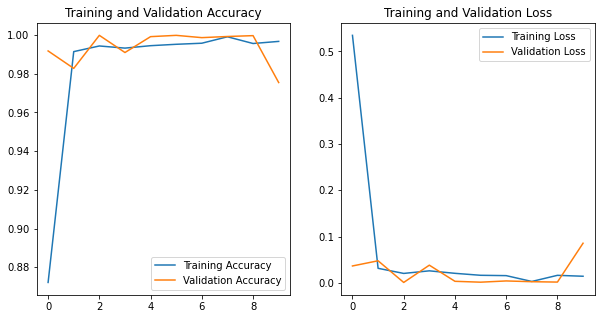

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/cnn_raw_2_training.png', dpi=400)

plt.show()

In [32]:
# filepath = './models/cnn_2_raw'
# save_model(model, filepath)

INFO:tensorflow:Assets written to: ./models/cnn_2_raw/assets


#### Trained on Augmented Images

In [33]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history = model.fit(
  aug_train_ds,
  validation_data=aug_val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 316s 186ms/step - loss: 1.0388 - accuracy: 0.7041 - val_loss: 0.3374 - val_accuracy: 0.8908
Epoch 2/10
1693/1693 [==============================] - 310s 183ms/step - loss: 0.2471 - accuracy: 0.9185 - val_loss: 0.2067 - val_accuracy: 0.9342
Epoch 3/10
1693/1693 [==============================] - 315s 186ms/step - loss: 0.1661 - accuracy: 0.9453 - val_loss: 0.1458 - val_accuracy: 0.9506
Epoch 4/10
1693/1693 [==============================] - 313s 185ms/step - loss: 0.1244 - accuracy: 0.9583 - val_loss: 0.1188 - val_accuracy: 0.9597
Epoch 5/10
1693/1693 [==============================] - 315s 186ms/step - loss: 0.1075 - accuracy: 0.9651 - val_loss: 0.0986 - val_accuracy: 0.9673
Epoch 6/10
1693/1693 [==============================] - 311s 184ms/step - loss: 0.0962 - accuracy: 0.9691 - val_loss: 0.1446 - val_accuracy: 0.9513
Epoch 7/10
1693/1693 [==============================] - 309s 182ms/step - loss: 0.0872 - accuracy: 0.9716 - val_

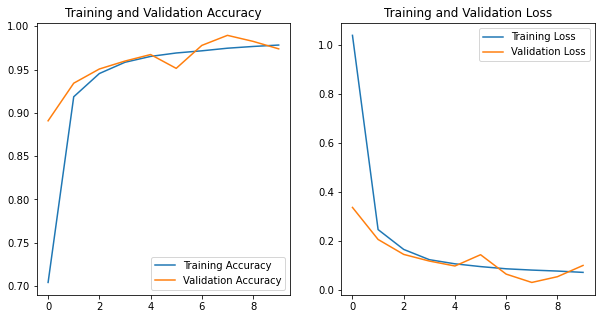

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/cnn_aug_2_training.png', dpi=400)

plt.show()

In [35]:
# filepath = './models/cnn_2_aug'
# save_model(model, filepath)

INFO:tensorflow:Assets written to: ./models/cnn_2_aug/assets


### 3 Convolutional Layers

#### Trained on Raw Images

In [64]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2022-03-29 20:12:49.495530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 405 of 1000
2022-03-29 20:12:55.121654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1693/1693 [==============================] - 74s 34ms/step - loss: 0.5403 - accuracy: 0.8639 - val_loss: 0.0157 - val_accuracy: 0.9957
Epoch 2/10
1693/1693 [==============================] - 44s 26ms/step - loss: 0.0455 - accuracy: 0.9879 - val_loss: 0.0724 - val_accuracy: 0.9760
Epoch 3/10
1693/1693 [==============================] - 45s 26ms/step - loss: 0.0390 - accuracy: 0.9892 - val_loss: 0.0620 - val_accuracy: 0.9903
Epoch 4/10
1693/1693 [==============================] - 45s 26ms/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 0.0029 - val_accuracy: 0.9993
Epoch 5/10
1693/1693 [==============================] - 43s 26ms/step - loss: 0.0248 - accuracy: 0.9931 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 6/10
1693/1693 [==============================] - 44s 26ms/step - loss: 0.0291 - accuracy: 0.9920 - val_loss: 0.0040 - val_accuracy: 0.9990
Epoch 7/10
1693/1693 [==============================] - 44s 26ms/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 6.5058e-04 - val_ac

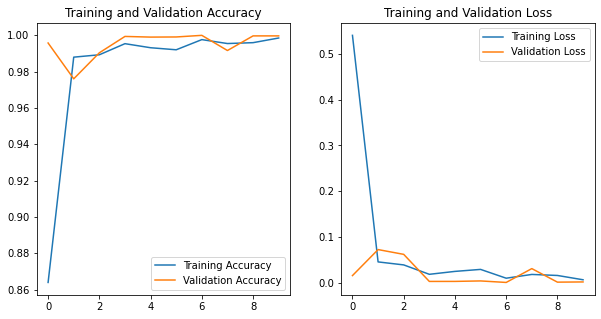

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/cnn_raw_3_training.png', dpi=400)

plt.show()

In [68]:
# filepath = './models/cnn_3_raw'
# save_model(model, filepath)

#### Training on Augmented Images

In [90]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history = model.fit(
  aug_train_ds,
  validation_data=aug_val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 320s 189ms/step - loss: 0.7011 - accuracy: 0.8038 - val_loss: 0.1960 - val_accuracy: 0.9371
Epoch 2/10
1693/1693 [==============================] - 315s 186ms/step - loss: 0.1422 - accuracy: 0.9524 - val_loss: 0.1010 - val_accuracy: 0.9659
Epoch 3/10
1693/1693 [==============================] - 318s 188ms/step - loss: 0.0972 - accuracy: 0.9670 - val_loss: 0.0798 - val_accuracy: 0.9715
Epoch 4/10
1693/1693 [==============================] - 316s 186ms/step - loss: 0.0755 - accuracy: 0.9754 - val_loss: 0.1312 - val_accuracy: 0.9571
Epoch 5/10
1693/1693 [==============================] - 316s 186ms/step - loss: 0.0712 - accuracy: 0.9777 - val_loss: 0.0704 - val_accuracy: 0.9761
Epoch 6/10
1693/1693 [==============================] - 319s 189ms/step - loss: 0.0612 - accuracy: 0.9804 - val_loss: 0.0324 - val_accuracy: 0.9887
Epoch 7/10
1693/1693 [==============================] - 316s 187ms/step - loss: 0.0594 - accuracy: 0.9810 - val_

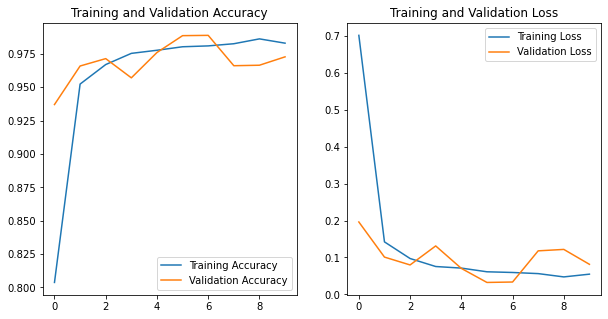

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/cnn_aug_3_training.png', dpi=400)

plt.show()

In [92]:
# filepath = './models/cnn_3_aug'
# save_model(model, filepath)

INFO:tensorflow:Assets written to: ./models/cnn_aug/assets


In [31]:
# model = load_model(filepath, compile = True)

### MobileNetV2

#### Training on Raw Images

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [25]:
IMG_SIZE = (100, 100)
IMG_SHAPE = IMG_SIZE + (3,)

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.models.Sequential([
                                    rescale,
                                    base_model,
                                    layers.MaxPooling2D(),
                                    layers.Flatten(),
                                    layers.Dense(128, activation='relu'),
                                    layers.Dense(num_classes)
                                ])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 68s 36ms/step - loss: 0.3936 - accuracy: 0.9207 - val_loss: 0.0146 - val_accuracy: 0.9990
Epoch 2/10
1693/1693 [==============================] - 55s 32ms/step - loss: 0.0071 - accuracy: 0.9996 - val_loss: 0.0038 - val_accuracy: 0.9999
Epoch 3/10
1693/1693 [==============================] - 55s 32ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/10
1693/1693 [==============================] - 56s 33ms/step - loss: 6.1937e-04 - accuracy: 1.0000 - val_loss: 8.4697e-04 - val_accuracy: 1.0000
Epoch 5/10
1693/1693 [==============================] - 55s 32ms/step - loss: 0.0097 - accuracy: 0.9976 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 6/10
1693/1693 [==============================] - 55s 33ms/step - loss: 2.6670e-04 - accuracy: 1.0000 - val_loss: 4.5387e-04 - val_accuracy: 1.0000
Epoch 7/10
1693/1693 [==============================] - 55s 32ms/step - loss: 1.0984e-04 - accuracy: 1.0000 

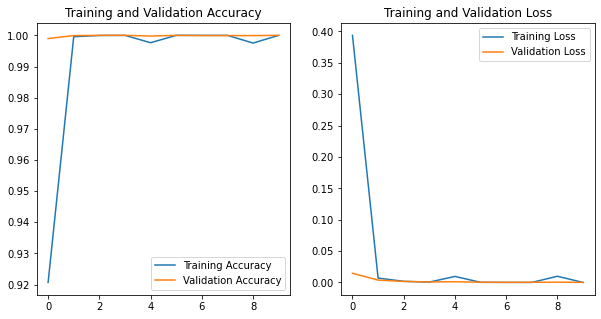

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

#plt.savefig('./models/MNV2_raw_training.png', dpi=400)

plt.show()

In [28]:
# filepath = './models/MNV2_raw'
# save_model(model, filepath)

2022-03-31 10:33:37.463713: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/MNV2_raw/assets


#### Training on Augmented Images

In [130]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.models.Sequential([
                                    rescale,
                                    base_model,
                                    layers.MaxPooling2D(),
                                    layers.Flatten(),
                                    layers.Dense(128, activation='relu'),
                                    layers.Dense(num_classes)
                                ])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [131]:
epochs = 10
history = model.fit(
  aug_train_ds,
  validation_data=aug_val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 330s 194ms/step - loss: 0.7158 - accuracy: 0.8261 - val_loss: 0.1759 - val_accuracy: 0.9469
Epoch 2/10
1693/1693 [==============================] - 325s 192ms/step - loss: 0.1097 - accuracy: 0.9673 - val_loss: 0.0702 - val_accuracy: 0.9797
Epoch 3/10
1693/1693 [==============================] - 328s 193ms/step - loss: 0.0679 - accuracy: 0.9782 - val_loss: 0.0518 - val_accuracy: 0.9843
Epoch 4/10
1693/1693 [==============================] - 327s 193ms/step - loss: 0.0525 - accuracy: 0.9834 - val_loss: 0.0544 - val_accuracy: 0.9817
Epoch 5/10
1693/1693 [==============================] - 327s 193ms/step - loss: 0.0457 - accuracy: 0.9847 - val_loss: 0.0541 - val_accuracy: 0.9827
Epoch 6/10
1693/1693 [==============================] - 328s 194ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.0403 - val_accuracy: 0.9866
Epoch 7/10
1693/1693 [==============================] - 328s 194ms/step - loss: 0.0339 - accuracy: 0.9890 - val_

In [132]:
# filepath = './models/MNV2_aug'
# save_model(model, filepath)

INFO:tensorflow:Assets written to: ./models/MNV2_aug/assets


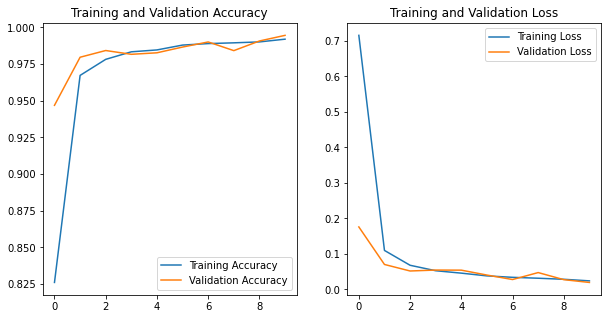

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./models/MNV2_aug_training.png', dpi=400)

plt.show()

## Model Evaluations

In [13]:
# load models

# 0 convolutional layer models
seq_raw = load_model('./models/seq_raw/', compile = True)
seq_aug = load_model('./models/seq_aug/', compile = True)

# 1 convolutional layer models
cnn_1_raw = load_model('./models/cnn_1_raw/', compile = True)
cnn_1_aug = load_model('./models/cnn_1_aug/', compile = True)

# 2 convolutional layer models
cnn_2_raw = load_model('./models/cnn_2_raw/', compile = True)
cnn_2_aug = load_model('./models/cnn_2_aug/', compile = True)

# 3 convolutional layer models
cnn_3_raw = load_model('./models/cnn_3_raw/', compile = True)
cnn_3_aug = load_model('./models/cnn_3_aug/', compile = True)

# MobileNetV2 models
mn_raw = load_model('./models/MNV2_raw/', compile = True)
mn_aug = load_model('./models/MNV2_aug/', compile = True)

In [80]:
def evaluate_model(model):
    
    # get raw image accuracies
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    for im, label in home_ds:
        true = []
        preds = []
        for i in range(len(im)):
            true.append(home_ds.class_names[label[i]])
            preds.append(train_ds.class_names[np.argmax(model.predict(np.expand_dims(im[i], axis=0)))])
    home_acc = accuracy_score(true, preds)
    
    # get augmented image accuracies
    aug_val_loss, aug_val_acc = model.evaluate(aug_val_ds, verbose=0)
    aug_test_loss, aug_test_acc = model.evaluate(aug_test_ds, verbose=0)
    for im, label in aug_home_ds:
        true = []
        preds = []
        for i in range(len(im)):
            true.append(home_ds.class_names[label[i]])
            preds.append(train_ds.class_names[np.argmax(model.predict(np.expand_dims(im[i], axis=0)))])
    aug_home_acc = accuracy_score(true, preds)
    
    # print results
    print(f'Val Raw:\t{val_acc}')
    print(f'Test Raw:\t{test_acc}')
    print(f'Home Raw:\t{home_acc}')
    
    print(f'Val Aug:\t{aug_val_acc}')
    print(f'Test Aug:\t{aug_test_acc}')
    print(f'Home Aug:\t{aug_home_acc}\n')

In [81]:
print('0 convolutional layer models')
print('Trained on raw:')
evaluate_model(seq_raw)
print('Trained on aug:')
evaluate_model(seq_aug)

print('1 convolutional layer models')
print('Trained on raw:')
evaluate_model(cnn_1_raw)
print('Trained on aug:')
evaluate_model(cnn_1_aug)

print('2 convolutional layer models')
print('Trained on raw:')
evaluate_model(cnn_2_raw)
print('Trained on aug:')
evaluate_model(cnn_2_aug)

print('3 convolutional layer models')
print('Trained on raw:')
evaluate_model(cnn_3_raw)
print('Trained on aug:')
evaluate_model(cnn_3_aug)

print('MobileNetV2 models')
print('Trained on raw:')
evaluate_model(mn_raw)
print('Trained on aug:')
evaluate_model(mn_aug)

0 convolutional layer models
Trained on raw:
Val Raw:	0.9894371628761292
Test Raw:	0.911891758441925
Home Raw:	0.0
Val Aug:	0.28061753511428833
Test Aug:	0.26247355341911316
Home Aug:	0.0

Trained on aug:
Val Raw:	0.8598020672798157
Test Raw:	0.7873325347900391
Home Raw:	0.05555555555555555
Val Aug:	0.8451026678085327
Test Aug:	0.7688645720481873
Home Aug:	0.1111111111111111

1 convolutional layer models
Trained on raw:
Val Raw:	0.9990397691726685
Test Raw:	0.9265691041946411
Home Raw:	0.0
Val Aug:	0.32789185643196106
Test Aug:	0.3151886463165283
Home Aug:	0.05555555555555555

Trained on aug:
Val Raw:	0.7524006366729736
Test Raw:	0.7083920836448669
Home Raw:	0.1111111111111111
Val Aug:	0.7274338603019714
Test Aug:	0.6905853152275085
Home Aug:	0.16666666666666666

2 convolutional layer models
Trained on raw:
Val Raw:	0.9754025936126709
Test Raw:	0.8837711811065674
Home Raw:	0.0
Val Aug:	0.2668045461177826
Test Aug:	0.2655148208141327
Home Aug:	0.05555555555555555

Trained on aug:
Val Ra

### Visualizing Results

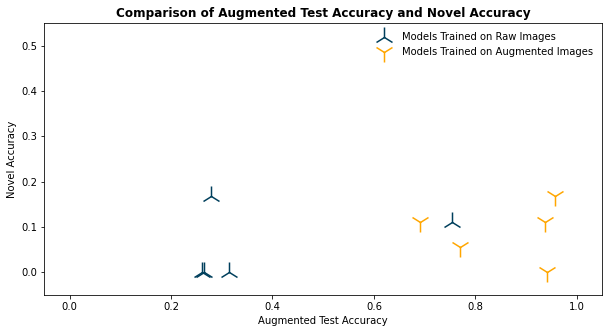

In [43]:
# novel accuracies
n_raw = [0.000, 0.000, 0.000, 0.167, 0.111]
n_aug = [0.056, 0.111, 0.000, 0.111, 0.167]

# augmented test accuracies
t_raw = [0.262, 0.315, 0.266, 0.278, 0.753]
t_aug = [0.769, 0.691, 0.942, 0.937, 0.956]

plt.figure(figsize=(10, 5))

plt.scatter(t_raw, n_raw, marker='2', c='#003f5c', s=400, 
            label='Models Trained on Raw Images')
plt.scatter(t_aug, n_aug, marker='1', c='#ffa600', s=400, 
            label='Models Trained on Augmented Images')

plt.xlim(-0.05,1.05)
plt.xlabel('Augmented Test Accuracy')
plt.ylim(-0.05,0.55)
plt.ylabel('Novel Accuracy')
plt.title('Comparison of Augmented Test Accuracy and Novel Accuracy', weight='semibold')

plt.legend(ncol=1, frameon=False)

# plt.savefig('novel_vs_test.png', dpi=400)

plt.show()

---